Given the same ligand, can you do arithmetic 
(protein-ligand complex embedding) - (protein embedding) + (new protein embedding) = (new protein-ligand complex embedding) ?

In [1]:
import os
import sys

# Get the current notebook's directory
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(os.path.dirname(current_directory))

# Add the parent directory to the module search path
sys.path.insert(0, parent_directory)
print(parent_directory)

/n/holylabs/LABS/mzitnik_lab/Users/afang/GET


In [2]:
from data.converter.pdb_to_list_blocks import pdb_to_list_blocks
from data.converter.sm_pdb_to_blocks import sm_pdb_to_blocks
import data.dataset
from data.atom3d_dataset import LBADataset
import models
import torch
from trainers.abs_trainer import Trainer
import importlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from models import DenoisePretrainModel, AffinityPredictor
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import itertools
import random
import scipy
from torch_scatter import scatter_sum

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
import importlib
importlib.reload(data.dataset)
from data.dataset import VOCAB
from data.dataset import blocks_interface, blocks_to_data
from data.dataset import BlockGeoAffDataset, PDBBindBenchmark, DynamicBatchWrapper

Finetuned model

In [3]:
# pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_112/checkpoint/epoch144_step61190.ckpt"
# model = torch.load(pretrain_ckpt, map_location='cpu')
# model = model.to("cuda")

Pretrained model

In [4]:
pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/pretrain/models/InteractNN-global/version_76/checkpoint/epoch8_step690593.ckpt" # pretrained only
model = AffinityPredictor.load_from_pretrained(pretrain_ckpt)
model = model.to("cuda")

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__in

## Protein Ligand case study
For proteins bound to the same ligand

In [70]:
dataset = LBADataset("/n/holylabs/LABS/mzitnik_lab/Users/afang/GET/datasets/LBA/split-by-sequence-identity-30/train")

fragmentation False
2024-02-22 15:08:46::INFO::Loading preprocessed data from /n/holylabs/LABS/mzitnik_lab/Users/afang/GET/datasets/LBA/split-by-sequence-identity-30/train.LBADataset_processed.pkl...


In [85]:
with open("adp_pdbs.txt", "r") as f:
    proteins = f.read().split("\n")
len(set(proteins))

31

In [86]:
protein_dataset = []
for d in dataset:
    if d["id"] not in proteins:
        continue
    protein_dataset.append(d)
proteins = [d["id"] for d in protein_dataset]
len(proteins)

28

In [87]:
embeddings = {}
batch_size = 8
for i in range(0, len(protein_dataset), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch = LBADataset.collate_fn(protein_dataset[i:i+batch_size])
        pdb_ids = [d["id"] for d in protein_dataset[i:i+batch_size]]
        minibatch = Trainer.to_device(minibatch, "cuda")
        pred_binding_affinity, output = model.infer(minibatch, extra_info=True)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [92]:
embeddings_all = {}
batch_size = 8
for i in range(0, len(dataset), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch = LBADataset.collate_fn(dataset[i:i+batch_size])
        pdb_ids = [d["id"] for d in dataset[i:i+batch_size]]
        minibatch = Trainer.to_device(minibatch, "cuda")
        pred_binding_affinity, output = model.infer(minibatch, extra_info=True)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings_all[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [88]:
pocket_only_embeddings = {}

for i in range(0, len(protein_dataset), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch_ = [BlockGeoAffDataset.filter_for_segment(d, 0) for d in protein_dataset[i:i+batch_size]]
        minibatch = LBADataset.collate_fn(minibatch_)
        pdb_ids = [d["id"] for d in protein_dataset[i:i+batch_size]]
        minibatch = Trainer.to_device(minibatch, "cuda")
        pred_binding_affinity, output = model.infer(minibatch, extra_info=True)
        for idx, pdb_id in enumerate(pdb_ids):
            pocket_only_embeddings[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [89]:
len(pocket_only_embeddings)

28

In [101]:
pairs = list(itertools.combinations(pocket_only_embeddings.keys(), 2))
dist_construct = []
dist_rand = []
cmplx_dist = []
for p1, p2 in pairs:
    p1_cmplx = embeddings[p1]
    p2_cmplx = embeddings[p2]
    p1_prot = pocket_only_embeddings[p1]
    p2_prot = pocket_only_embeddings[p2]

    p1_cmplx_construct = p2_cmplx - p2_prot + p1_prot
    p2_cmplx_construct = p1_cmplx - p1_prot + p2_prot
    
    rand_p1_cmplx = random.choice(list(embeddings_all.values()))
    rand_p2_cmplx = random.choice(list(embeddings_all.values()))

    # rand_p1_cmplx = np.mean(list(embeddings.values()), axis=0)
    # rand_p2_cmplx = np.mean(list(embeddings.values()), axis=0)

    dist_construct.append(np.linalg.norm(p1_cmplx_construct - p1_cmplx))
    dist_construct.append(np.linalg.norm(p2_cmplx_construct - p2_cmplx))
    dist_rand.append(np.linalg.norm(p1_cmplx - rand_p1_cmplx))
    dist_rand.append(np.linalg.norm(p2_cmplx - rand_p2_cmplx))
    cmplx_dist.append(np.linalg.norm(p1_cmplx - p2_cmplx))
    cmplx_dist.append(np.linalg.norm(p1_cmplx - p2_cmplx))


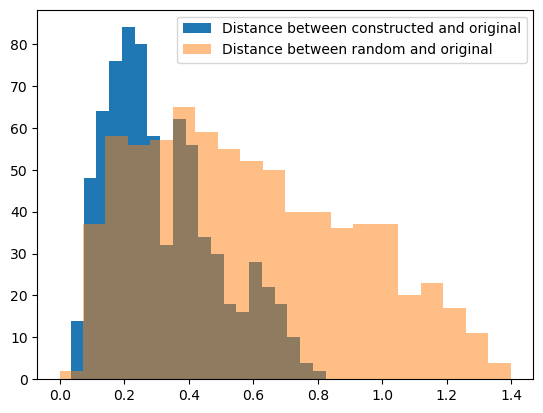

In [106]:
plt.hist(dist_construct, bins=20, alpha=1, label="Distance between constructed and original")
plt.hist(dist_rand, bins=20, alpha=0.5, label="Distance between random and original")
plt.legend()
plt.show()

Baseline is distance of protein-ligand complex to any protein-ligand complex (does not have to be of the same ligand)

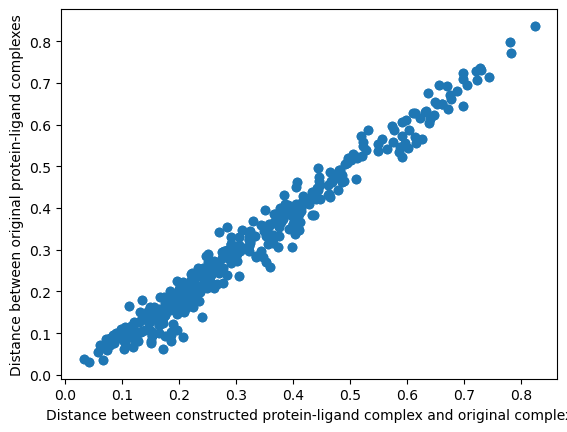

In [102]:
plt.scatter(dist_construct, cmplx_dist)
plt.xlabel("Distance between constructed protein-ligand complex and original complex")
plt.ylabel("Distance between original protein-ligand complexes")
plt.show()

This does hold, but it is just because if the original complexes have very similar graph embeddings then the compositional relationship holds.

If the original complexes have very different graph embeddings, then the compositional relationship does not hold.

## Protein Ligand and Nucleotide Ligand Case Study
What about for a protein bound to a ligand and a nucleotide bound to the same ligand?
i.e. does (protein-ligand complex embedding) - (protein embedding) + (nucleotide embedding) = (nucleotide-ligand complex embedding) ? 

In [20]:
dataset_pl = LBADataset("/n/holylabs/LABS/mzitnik_lab/Users/afang/GET/datasets/LBA/split-by-sequence-identity-30/train")
dataset_nl = BlockGeoAffDataset('/n/holylabs/LABS/mzitnik_lab/Users/afang/GET/datasets/NL/processed/PDBbind.pkl')

fragmentation False
2024-02-22 14:45:59::INFO::Loading preprocessed data from /n/holylabs/LABS/mzitnik_lab/Users/afang/GET/datasets/LBA/split-by-sequence-identity-30/train.LBADataset_processed.pkl...
2024-02-22 14:45:59::INFO::Loading preprocessed data from /n/holylabs/LABS/mzitnik_lab/Users/afang/GET/datasets/NL/processed/PDBbind.BlockGeoAffDataset_processed.pkl...


In [8]:
with open("sam_pdbs.txt", "r") as f:
    pdbs = f.read().split("\n")
len(set(pdbs))

20

In [29]:
filtered_dataset_nl = []
nl_pdbs = []
for idx, d in enumerate(dataset_nl.indexes):
    if d["id"] not in pdbs:
        continue
    filtered_dataset_nl.append(dataset_nl[idx])
    nl_pdbs.append(d["id"])
len(filtered_dataset_nl)

8

In [22]:
filtered_dataset_pl = []
pl_pdbs = []
for d in dataset_pl:
    if d["id"] not in pdbs:
        continue
    pl_pdbs.append(d["id"])
    filtered_dataset_pl.append(d)
len(filtered_dataset_pl)

11

In [42]:
embeddings_pl = {}
batch_size = 8
for i in range(0, len(filtered_dataset_pl), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch = LBADataset.collate_fn(filtered_dataset_pl[i:i+batch_size])
        pdb_ids = [d["id"] for d in filtered_dataset_pl[i:i+batch_size]]
        minibatch = Trainer.to_device(minibatch, "cuda")
        pred_binding_affinity, output = model.infer(minibatch, extra_info=True)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings_pl[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [43]:
embeddings_p = {}
for i in range(0, len(filtered_dataset_pl), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch_ = [BlockGeoAffDataset.filter_for_segment(d, 0) for d in filtered_dataset_pl[i:i+batch_size]]
        minibatch = LBADataset.collate_fn(minibatch_)
        pdb_ids = [d["id"] for d in filtered_dataset_pl[i:i+batch_size]]
        minibatch = Trainer.to_device(minibatch, "cuda")
        pred_binding_affinity, output = model.infer(minibatch, extra_info=True)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings_p[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [44]:
embeddings_nl = {}
for i in range(0, len(filtered_dataset_nl), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch = BlockGeoAffDataset.collate_fn(filtered_dataset_nl[i:i+batch_size])
        pdb_ids = nl_pdbs[i:i+batch_size]
        minibatch = Trainer.to_device(minibatch, "cuda")
        pred_binding_affinity, output = model.infer(minibatch, extra_info=True)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings_nl[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [65]:
embeddings_nl_all = {}
for i in range(0, len(dataset_nl), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch = BlockGeoAffDataset.collate_fn(dataset_nl[i:i+batch_size])
        pdb_ids = [d["id"] for d in dataset_nl.indexes[i:i+batch_size]]
        minibatch = Trainer.to_device(minibatch, "cuda")
        pred_binding_affinity, output = model.infer(minibatch, extra_info=True)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings_nl_all[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [47]:
embeddings_n = {}
for i in range(0, len(filtered_dataset_nl), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch_ = [BlockGeoAffDataset.filter_for_segment(d, 0) for d in filtered_dataset_nl[i:i+batch_size]]
        minibatch = BlockGeoAffDataset.collate_fn(minibatch_)
        pdb_ids = nl_pdbs[i:i+batch_size]
        minibatch = Trainer.to_device(minibatch, "cuda")
        pred_binding_affinity, output = model.infer(minibatch, extra_info=True)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings_n[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [112]:
pl_constr_dist = []
nl_constr_dist = []
rand_dist1 = []
rand_dist2 = []
pl_nl_dist = []
pairs = list(itertools.product(pl_pdbs, nl_pdbs))
for pl_pdb, nl_pdb in pairs:
    pl_embedding = embeddings_pl[pl_pdb]
    nl_embedding = embeddings_nl[nl_pdb]

    pl_constr = embeddings_nl[nl_pdb] - embeddings_n[nl_pdb] + embeddings_p[pl_pdb]
    nl_constr = embeddings_pl[pl_pdb] - embeddings_p[pl_pdb] + embeddings_n[nl_pdb]

    pl_constr_dist.append(np.linalg.norm(pl_constr - pl_embedding))
    nl_constr_dist.append(np.linalg.norm(nl_constr - nl_embedding))
    rand_dist1.append(np.linalg.norm(pl_embedding - np.random.randn(pl_embedding.size)))
    rand_dist2.append(np.linalg.norm(pl_embedding - random.choice(list(embeddings_nl_all.values()))))
    pl_nl_dist.append(np.linalg.norm(pl_embedding - nl_embedding))

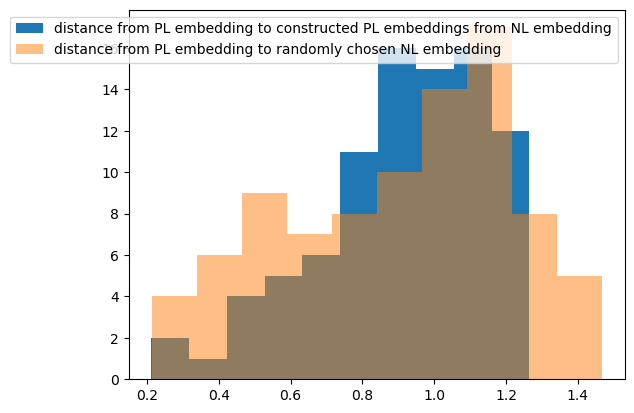

In [69]:
plt.hist(pl_constr_dist, label = "distance from PL embedding to constructed PL embeddings from NL embedding")
# plt.hist(rand_dist1, label = "distance from PL embedding to random embeddings")
plt.hist(rand_dist2, alpha=0.5, label = "distance from PL embedding to randomly chosen NL embedding")
plt.legend()
plt.show()

Baseline is distance of protein-ligand complex to any nucleotide-ligand complex (does not have to be of the same ligand)

It looks like it does not really hold.

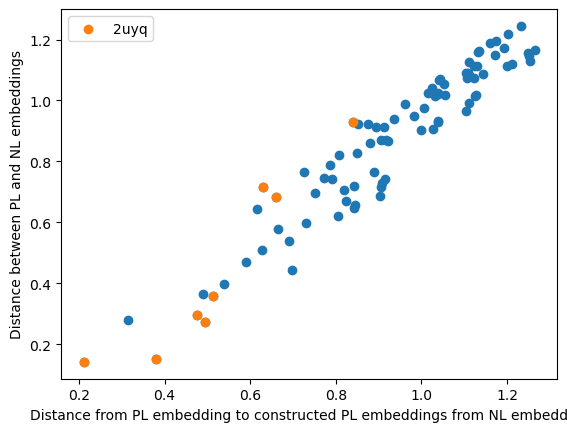

In [135]:
plt.scatter(pl_constr_dist, pl_nl_dist)
plt.xlabel("Distance from PL embedding to constructed PL embeddings from NL embedding")
plt.ylabel("Distance between PL and NL embeddings")
plt.scatter([d for d, p in zip(pl_constr_dist, pairs) if p[0] == "2uyq"], [d for d, p in zip(pl_nl_dist, pairs) if p[0] == "2uyq"], label = "2uyq")
plt.legend()
plt.show()

2uyq is missing its sulfur tail in SAM for some reason, but we can see that it is more similar to the NL complexes with SAM as it has no opportunity to engage in sulfur-sulfur interactions.

## What does this show us?
For the same ligand if it interacts similarly to the pocket, the compositional relationship holds. If it interacts differently, the compositional relationship does not hold.

In [121]:
len(pairs)

88

In [127]:
sulfur = VOCAB.abrv_to_idx("S")
sulfur

47

In [129]:
for p in filtered_dataset_pl:
    print(p["id"], sulfur in p["B"])

5h5f True
5twj True
1nw5 True
2h21 True
5kva True
3r24 True
2uyq False
4ymg True
4bup True
6bm5 True
5bw4 True


In [132]:
pairs[pl_nl_dist.index(sorted(pl_nl_dist)[3])]

('6bm5', '4oqu')

### Most distant PL and NLs
('5kva', '2ydh') for this PL and NL which are most distant, SAM interacts with the protein and nucleotide differently. 
* In 5kva, SAM interacts with the protein has a sulfur-sulfur bridge with a MET residue.
* In 2ydh, this is not present as this nucleotides do not have any sulfurs.

('4ymg', '2ydh') for this PL and NL which is second most distant: 4ymg and 2ydh have a separate set of intermolecular interactions that they engage in, though both are hydrogen bonds, it is different parts or amounts that engage in the hydrogen bonds.

### Closest PL and NLs
('6bm5', '4oqu') and (2uyq, some NL) are quite close to NLs because they do not engage in sulfur-sulfur interactions.

## What can we use this model for then?
Test similarity of interfaces? Similarity of interaction of ligands with different proteins?

Cluster PPI interfaces? for different mechanisms of interaction?

Are there useful zero shot tasks where similarity of interaction is important?